## Requirements

### Imports

In [17]:
import os
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import IntegratedGradients, Saliency, GradientShap, Occlusion
from captum.attr import visualization as viz

In [18]:
import training

In [19]:
torch.manual_seed(42)

### Paths

In [20]:
SRC_DIR = Path.cwd()
ROOT_DIR = SRC_DIR.parent

DATA_DIR = os.path.join(ROOT_DIR, 'dataset')
PREPROCESSED_DIR = os.path.join(DATA_DIR, 'preprocessed')
CSV_PATH = os.path.join(DATA_DIR, 'csv_mappings', 'train.csv')

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
BASELINE_DIR = os.path.join(MODEL_DIR, 'baselines_finetuned')
RESULT_DIR = os.path.join(BASELINE_DIR, 'results')

### Load Data

In [21]:
BATCH_SIZE = 32

In [22]:
CLASS_NAMES = {
    0: "amanita",
    1: "boletus",
    2: "chantelle",
    3: "deterrimus",
    4: "rufus",
    5: "torminosus",
    6: "aurantiacum",
    7: "procera",
    8: "involutus",
    9: "russula"
}

In [23]:
train_loader, val_loader, test_loader = training.get_data_loaders(PREPROCESSED_DIR, CSV_PATH, BATCH_SIZE)

### Training

##### Training config

In [24]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NUM_CLASSES = 10 
EPOCHS = 20
PATIENCE = 3
LEARNING_RATE = 0.0001

SCHEDULER = 'StepLR' # StepLR # OneCycleLR # None

##### Load model to explain

In [25]:
model_type = 'custom_resnet'  

# alexnet # resnet # vgg16 # densenet # efficientnet
# custom_alexnet custom_resnet 

In [26]:
model = training.load_model_for_explaining(model_type, NUM_CLASSES, DEVICE, finetuned=True)

c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\src\training.py:379: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicit

RuntimeError: Error(s) in loading state_dict for EnhancedResNet:
	size mismatch for fc1.weight: copying a param with shape torch.Size([1024, 2048]) from checkpoint, the shape in current model is torch.Size([2048, 2048]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([10, 1024]) from checkpoint, the shape in current model is torch.Size([10, 2048]).

##### Explain model

In [11]:
def explain_with_integrated_gradients(model, input_tensor, target_class, device):
    model.eval()
    input_tensor = input_tensor.to(device)
    
    ig = IntegratedGradients(model)
    attributions, _ = ig.attribute(input_tensor, target=target_class, return_convergence_delta=True)
    return attributions.cpu().detach().numpy()


def explain_with_saliency(model, input_tensor, target_class, device):
    model.eval()
    input_tensor = input_tensor.to(device)
    
    saliency = Saliency(model)
    attributions = saliency.attribute(input_tensor, target=target_class)
    return attributions.cpu().detach().numpy()


def explain_with_gradient_shap(model, input_tensor, target_class, device):
    model.eval()
    input_tensor = input_tensor.to(device)
    
    baseline = torch.zeros_like(input_tensor).to(device)
    gradient_shap = GradientShap(model)
    attributions = gradient_shap.attribute(input_tensor, baselines=baseline, target=target_class)
    return attributions.cpu().detach().numpy()


def explain_with_occlusion(model, input_tensor, target_class, device):
    model.eval()
    input_tensor = input_tensor.to(device)
    
    occlusion = Occlusion(model)
    sliding_window_shape = (input_tensor.shape[1], 15, 15)  
    attributions = occlusion.attribute(input_tensor, target=target_class, sliding_window_shapes=sliding_window_shape)
    return attributions.cpu().detach().numpy()


def visualize_attributions(attributions, original_image, class_name):
    attributions = np.transpose(attributions[0], (1, 2, 0))
    original_image = np.transpose(original_image[0], (1, 2, 0))
    _ = viz.visualize_image_attr(attributions, original_image, method="blended_heat_map", sign="positive",
                                 show_colorbar=True, title=f"Explanation for class: {class_name}")


def generate_explanations(model, input_tensor, target_class, class_names, device):
    original_image = input_tensor.cpu().detach().numpy()
    target_class_name = class_names[target_class]

    ig_attr = explain_with_integrated_gradients(model, input_tensor, target_class, device)
    saliency_attr = explain_with_saliency(model, input_tensor, target_class, device)
    gradient_shap_attr = explain_with_gradient_shap(model, input_tensor, target_class, device)
    occlusion_attr = explain_with_occlusion(model, input_tensor, target_class, device)

    plt.figure(figsize=(20, 10))

    plt.subplot(2, 2, 1)
    visualize_attributions(ig_attr, original_image, f"IG: {target_class_name}")

    plt.subplot(2, 2, 2)
    visualize_attributions(saliency_attr, original_image, f"Saliency: {target_class_name}")

    plt.subplot(2, 2, 3)
    visualize_attributions(gradient_shap_attr, original_image, f"Gradient SHAP: {target_class_name}")

    plt.subplot(2, 2, 4)
    visualize_attributions(occlusion_attr, original_image, f"Occlusion: {target_class_name}")

    plt.show()


g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\git\mushroom_classification\src\training.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(image_pa

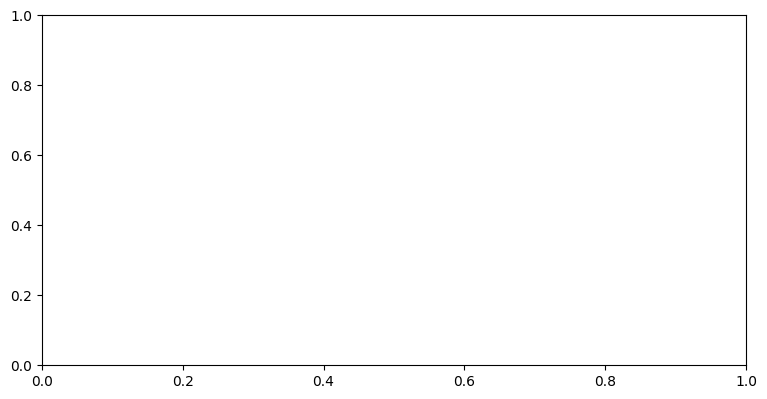

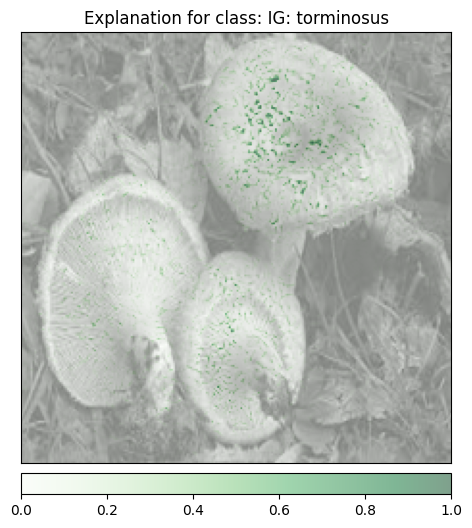

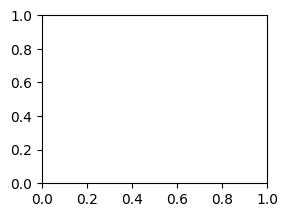

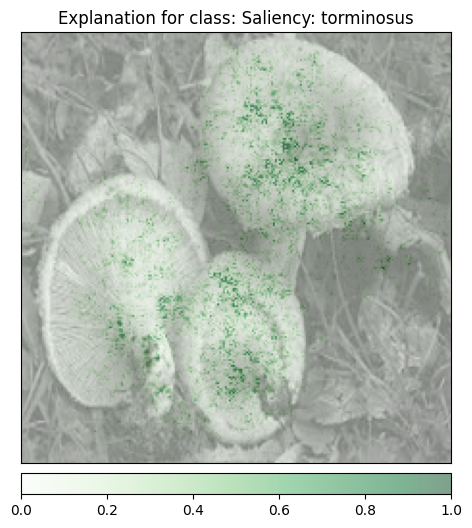

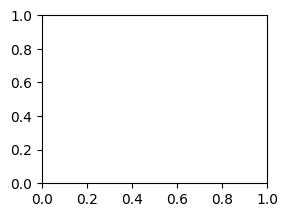

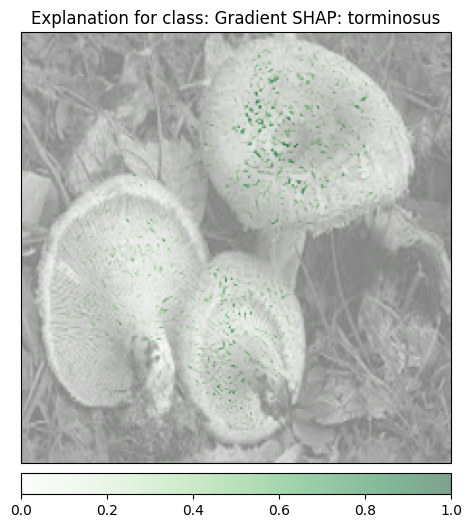

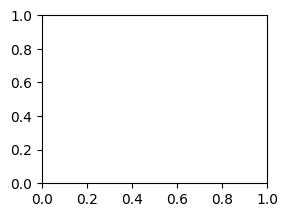

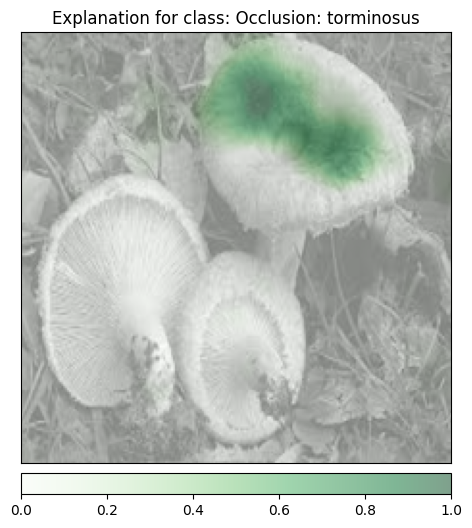

In [12]:
for batch in test_loader:
    inputs, labels = batch 
    input_tensor = inputs[0].unsqueeze(0)  
    target_class = labels[0].item() 
    break  

generate_explanations(model, input_tensor, target_class, CLASS_NAMES, DEVICE)

In [29]:
# Print the model's layer names and corresponding module types
def print_model_layers(model):
    for name, module in model.named_modules():
        print(f"Layer Name: {name}, Layer Type: {module.__class__.__name__}")

# Call the function to print the layers of your model
print_model_layers(model)


Layer Name: , Layer Type: AlexNet
Layer Name: features, Layer Type: Sequential
Layer Name: features.0, Layer Type: Conv2d
Layer Name: features.1, Layer Type: ReLU
Layer Name: features.2, Layer Type: MaxPool2d
Layer Name: features.3, Layer Type: Conv2d
Layer Name: features.4, Layer Type: ReLU
Layer Name: features.5, Layer Type: MaxPool2d
Layer Name: features.6, Layer Type: Conv2d
Layer Name: features.7, Layer Type: ReLU
Layer Name: features.8, Layer Type: Conv2d
Layer Name: features.9, Layer Type: ReLU
Layer Name: features.10, Layer Type: Conv2d
Layer Name: features.11, Layer Type: ReLU
Layer Name: features.12, Layer Type: MaxPool2d
Layer Name: avgpool, Layer Type: AdaptiveAvgPool2d
Layer Name: classifier, Layer Type: Sequential
Layer Name: classifier.0, Layer Type: Dropout
Layer Name: classifier.1, Layer Type: Linear
Layer Name: classifier.2, Layer Type: ReLU
Layer Name: classifier.3, Layer Type: Dropout
Layer Name: classifier.4, Layer Type: Linear
Layer Name: classifier.5, Layer Type: